In [340]:
import os, time
import numpy as np
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from torchsummary import summary
device = "cuda"

In [174]:
def get_dataset_mean_std(dataloader):
    print("Calculate distribution:")
    mean = 0.
    std = 0.
    nb_samples = 0.
    for data in dataloader:
        img, label = data
        batch_samples = img.size(0)
        img = img.view(batch_samples, img.size(1), -1)
        mean += img.mean(2).sum(0)
        std += img.std(2).sum(0)
        nb_samples += batch_samples
        if nb_samples%5000 == 0:
            print("Finished:", nb_samples)
    print("num of samples:",nb_samples)
    mean /= nb_samples
    std /= nb_samples
#     print("Average mean:",mean)
#     print("Average std:", std)
    return mean.cpu().numpy(), std.cpu().numpy()

In [341]:
import torch.nn as nn
import torch.nn.functional as F
class convNet(nn.Module):
    def __init__(self,in_channels):
        super(convNet,self).__init__()
        #torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, 
        #                dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.c1 = nn.Conv2d(in_channels=in_channels, out_channels=64,kernel_size=3,stride=1,padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=64,momentum=0.1)
        self.c2 = nn.Conv2d(64,64,3,1,1)
        self.bn2 = nn.BatchNorm2d(num_features=64,momentum=0.1)
        self.m1 = nn.MaxPool2d(2)
        self.d1 = nn.Dropout(0.2)
        
        self.c3 = nn.Conv2d(64,128,3,1,1)
        self.bn3 = nn.BatchNorm2d(128,0.1)
        self.c4 = nn.Conv2d(128,128,3,1,1)
        self.bn4 = nn.BatchNorm2d(128,0.1)
        self.m2 = nn.MaxPool2d(2)
        self.d2 = nn.Dropout(0.2)
        
        self.c5 = nn.Conv2d(128,256,3,1,1)
        self.bn5 = nn.BatchNorm2d(256,0.1)
        self.c6 = nn.Conv2d(256,256,3,1,1)
        self.bn6 = nn.BatchNorm2d(256,0.1)
        self.m3 = nn.MaxPool2d(2)
        self.d3 = nn.Dropout(0.2)
        
        self.fc1 = nn.Linear(256*3*3,512)
        self.out = nn.Linear(512,10)

    def forward(self,x):
        x = F.leaky_relu(self.bn1(self.c1(x)),negative_slope=0.1)
        x = F.leaky_relu(self.bn2(self.c2(x)),0.1)
        x = self.m1(x)
        x = self.d1(x)
        
        x = F.leaky_relu(self.bn3(self.c3(x)),0.1)
        x = F.leaky_relu(self.bn4(self.c4(x)),0.1)
        x = self.m2(x)
        x = self.d2(x)
        
        x = F.leaky_relu(self.bn5(self.c5(x)),0.1)
        x = F.leaky_relu(self.bn6(self.c6(x)),0.1)
        x = self.m3(x)
        x = self.d3(x)
        
        x = x.view(-1, 256*3*3) #reshape
        x = F.leaky_relu(self.fc1(x),0.1)
        return self.out(x)
                

In [342]:
trans = transforms.Compose([
#         transforms.RandomResizedCrop(28),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
        transforms.ColorJitter(0.1,0.1,0.1,0.1),
        transforms.RandomAffine(degrees=25,translate=None,scale=[0.7,1.3]),
        transforms.ToTensor(),  #Take Image as input and convert to tensor with value from 0 to1
        transforms.Normalize(mean=[0.08194405],std=[0.238141])  #comment this line when calculate ditribution
    ])

trans_val = transforms.Compose([
        transforms.ToTensor(),  #Take Image as input and convert to tensor with value from 0 to1
        transforms.Normalize(mean=[0.08544743],std=[0.24434312]) #comment this line when calculate ditribution
    ])

trans_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.07261261],std=[0.22267216])
])

class KMnistDataset(Dataset):
    def __init__(self,data_len=None, is_validate=False,validate_rate=None):
        self.is_validate = is_validate
        self.data = pd.read_csv("./dataset/train.csv")
        print("data shape:", np.shape(self.data))
        if data_len == None:
            data_len = len(self.data)
        
        if self.is_validate:
            self.len = int(data_len*validate_rate)
            self.offset = int(data_len*(1-validate_rate))
            self.transform = trans_val
        else:
            self.len = int(data_len*(1-validate_rate))
            self.offset = 0
            self.transform = trans
        
    def __getitem__(self, idx):
        idx += self.offset
        img = self.data.iloc[idx, 1:].values.astype(np.uint8).reshape((28, 28))  #value: 0~255
        label = self.data.iloc[idx, 0]  #(num,)
        img = Image.fromarray(img)
        img = self.transform(img)     #value: 0~1, shape:(1,28,28)
        label = torch.as_tensor(label, dtype=torch.uint8)    #value: 0~9, shape(1)
        return img, label

    def __len__(self):
        return self.len

class TestDataset(Dataset):
    def __init__(self,data_len=None):
        self.data = pd.read_csv("./dataset/test.csv")
        print("data shape:", np.shape(self.data))
        self.transform = trans_val
        if data_len == None:
            self.len = len(self.data)
        
    def __getitem__(self, idx):
        img = self.data.iloc[idx, 1:].values.astype(np.uint8).reshape((28, 28))  #value: 0~255
        img = Image.fromarray(img)
        img = self.transform(img)     #value: 0~1, shape:(1,28,28)
        return img, torch.Tensor([])

    def __len__(self):
        return self.len

In [343]:
batch_size = 256
num_workers = 0

vr = 0.1
train_dataset = KMnistDataset(data_len=None,is_validate=False, validate_rate=vr)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
# mean, std = get_dataset_mean_std(train_loader)
# print("train distribution:",mean, std)

validate_dataset = KMnistDataset(data_len=None,is_validate=True, validate_rate=vr)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
# mean, std = get_dataset_mean_std(validate_loader)
# print("validate distribution:",mean, std)

test_dataset = TestDataset(data_len=None)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
# mean, std = get_dataset_mean_std(test_loader)
# print("validate distribution:",mean, std)


data shape: (60000, 785)
data shape: (60000, 785)
data shape: (5000, 785)


In [17]:
data = pd.read_csv("./dataset/train.csv")

In [ ]:
for i in range(1000,1050):
    fig, axes = plt.subplots(1,2,figsize=(8,4))
    img2 = data.iloc[i, 1:].values.astype(np.uint8).reshape((28, 28))  #value: 0~255
    img2 = Image.fromarray(img2)
    axes[0].imshow(img2,cmap="gray")
    img2 = trans(img2).cpu().numpy().reshape(28,28)
    axes[1].imshow(img2,cmap="gray")
    plt.pause(.1)


In [ ]:
kmnist_dataset.data.head(100)

In [ ]:
type(kmnist_dataset.data.iloc[20,1:].values)  #numpy ndarray
type(kmnist_dataset.data.iloc[20,0])  #numpy int64
kmnist_dataset.data.head(5)

In [344]:
model = convNet(in_channels=1)
model.cuda()
# model.load_state_dict(torch.load("./Kmnist_saved_model/ep20_acc0.9910"))
summary(model, input_size=(1, 28, 28))
# count_parameters(convNet(1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
       BatchNorm2d-2           [-1, 64, 28, 28]             128
            Conv2d-3           [-1, 64, 28, 28]          36,928
       BatchNorm2d-4           [-1, 64, 28, 28]             128
         MaxPool2d-5           [-1, 64, 14, 14]               0
           Dropout-6           [-1, 64, 14, 14]               0
            Conv2d-7          [-1, 128, 14, 14]          73,856
       BatchNorm2d-8          [-1, 128, 14, 14]             256
            Conv2d-9          [-1, 128, 14, 14]         147,584
      BatchNorm2d-10          [-1, 128, 14, 14]             256
        MaxPool2d-11            [-1, 128, 7, 7]               0
          Dropout-12            [-1, 128, 7, 7]               0
           Conv2d-13            [-1, 256, 7, 7]         295,168
      BatchNorm2d-14            [-1, 25

In [329]:
import math
class CosineAnnealingWarmUpRestarts(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
        self.T_cur = last_epoch
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

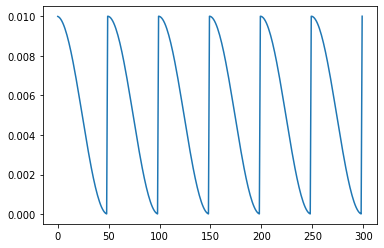

In [347]:
lr = 1e-2
ep = 300
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=50,T_mult=1,eta_min=0) #original 
# scheduler = CosineAnnealingWarmUpRestarts(optimizer,T_0=20,T_mult=3,eta_max=lr,T_up=10)  #advance
plt.figure()
x = list(range(ep))
y = []
for epoch in range(ep):
    lr_scheduler.step()
    lr = lr_scheduler.get_lr()
    y.append(lr_scheduler.get_lr()[0])
plt.plot(x, y)

In [ ]:
if __name__ == "__main__":
    epochs = 300
    max_acc = 0
    data_num = 0
    loss_avg = 0
    lr = 1e-2
    validate_ep = 10

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),lr=lr)
#     optimizer = torch.optim.RMSprop(model.parameters(),lr=lr,alpha=0.9)
#     optimizer = torch.optim.Adam(model.parameters(),lr=lr,betas=(0.9,0.99))
#     optimizer = torch.optim.Adagrad(model.parameters(),lr=lr)

    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=50,T_mult=1,eta_min=0) #original 
#     lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=3)
    
    for ep in range(0,epochs+1):
        model.train()
        for idx, data in enumerate(train_loader):
            img, target = data
            img, target = img.to(device), target.to(device,dtype=torch.long)
#             print(np.shape(img),np.shape(target)) #Tensor(4,1,28,28), Tensor(4)
#             print(np.max(img.cpu().numpy()),np.min(img.cpu().numpy())) #1.0 0.0
            
            pred = model(img)
#             print(pred.size())   #(32,10)
#             print(target.size()) #(32,)
            ###Input shape must be pred:, target:
            loss = criterion(pred,target)
        
            loss_avg += loss.item()
            data_num += img.size(0)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        lr_scheduler.step()
        
        ###Evaluate Train Loss 
        if ep%2 == 0:
            loss_avg /= data_num
            print("Ep:{}, loss:{}, lr:{}".format(ep, loss_avg, lr_scheduler.get_lr()))
            loss_avg = 0
            data_num = 0
        
        ###Validation
        if ep!=0 and ep%validate_ep == 0:
            model.eval()
            acc = 0
            val_loss = 0
            data_num  = 0
            with torch.no_grad():
                for idx, data in enumerate(validate_loader):
                    img, target = data
                    img, target = img.to(device), target.to(device,dtype=torch.long)
                    pred = model(img)
                    val_loss += criterion(pred, target)
                    # print(pred)
                    _,pred_class = torch.max(pred.data, 1)
#                     print(pred_class)
                    acc += (pred_class == target).sum().item()
                    data_num += img.size(0)
            
            acc /= data_num
            val_loss /= data_num
#             lr_scheduler.step(val_loss)
            
            if acc > max_acc:
                max_acc = acc
                if max_acc > 0.98 :
                    print("===================Best Model Saved:==================")                    
                    torch.save(model.state_dict(), "./Kmnist_saved_model/ep{}_acc{:.4f}".format(ep,max_acc))
                    print("======================================================")
            print("Episode:{}, Validation Loss:{}, Acc:{:.4f}%".format(ep,val_loss,acc*100))
            
# if __name__ == "__main__":
#     main()
    

Ep:0, loss:0.0003257340074827274, lr:[0.009990133642141357]
Ep:2, loss:0.00029392988303745236, lr:[0.009911436253643444]
Ep:4, loss:0.00024993553987048844, lr:[0.009755282581475769]
Ep:6, loss:0.00022811315563955794, lr:[0.009524135262330098]
Ep:8, loss:0.00020791198339106307, lr:[0.009221639627510075]
Ep:10, loss:0.0001941460323933926, lr:[0.008852566213878947]
===================Best Model Saved:==================
Episode:10, Validation Loss:0.00011060683755204082, Acc:99.0167%
Ep:12, loss:0.00017073093067952676, lr:[0.008422735529643444]
Ep:14, loss:0.0001722320325638133, lr:[0.007938926261462366]
Ep:16, loss:0.00016296096021930378, lr:[0.0074087683705085765]
Ep:18, loss:0.00015689395299112356, lr:[0.006840622763423391]
Ep:20, loss:0.00015118263022008318, lr:[0.006243449435824273]
===================Best Model Saved:==================
Episode:20, Validation Loss:0.00010137426579603925, Acc:99.1333%
Ep:22, loss:0.00013518809265734857, lr:[0.005626666167821522]
Ep:24, loss:0.000142894